## Import's

In [1]:
import pandas as pd
import sqlite3

## Подключение к БД

In [2]:
conn = sqlite3.connect('../data/checking-logs.sqlite')

In [3]:
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)

,name
0,pageviews
1,checker
2,deadlines


In [4]:
schema = pd.read_sql("PRAGMA table_info(pageviews);", conn)
schema

,cid,name,type,notnull,dflt_value,pk
0,0,index,INTEGER,0,None,0
1,1,uid,TEXT,0,None,0
2,2,datetime,TIMESTAMP,0,None,0


## Забираем время пользователя на странице

In [5]:
query = '''
SELECT datetime
FROM pageviews
WHERE uid LIKE 'user_%'
'''

df = pd.read_sql(query, conn)
df

,datetime
0,2020-04-17 22:46:26.785035
1,2020-04-18 10:53:52.623447
2,2020-04-18 10:56:55.833899
3,2020-04-18 10:57:37.331258
4,2020-04-18 12:05:48.200144
...,...
982,2020-05-21 18:45:20.441142
983,2020-05-21 23:03:06.457819
984,2020-05-21 23:23:49.995349
985,2020-05-22 11:30:18.368990


## Забираем время комита

In [6]:
commits_query = '''
SELECT DATE(timestamp) as date, COUNT(*) as commits
FROM checker
WHERE uid LIKE 'user_%' AND timestamp IS NOT NULL
GROUP BY date
'''

commits_df = pd.read_sql(commits_query, conn)
commits_df['date'] = pd.to_datetime(commits_df['date']).dt.date

## Преобразования и групировка по времени

In [7]:
df['datetime'] = pd.to_datetime(df['datetime'])

df['date'] = df['datetime'].dt.date
views_per_day = df.groupby('date').size().reset_index(name='views')

In [11]:
views_per_day = views_per_day[views_per_day['date'].isin(commits_df['date'])]
views_per_day

,date,views
0,2020-04-17,1
1,2020-04-18,23
2,2020-04-19,15
3,2020-04-21,3
4,2020-04-22,1
5,2020-04-23,5
6,2020-04-25,1
7,2020-04-26,8
8,2020-04-28,2
9,2020-04-29,4


## Построение графика

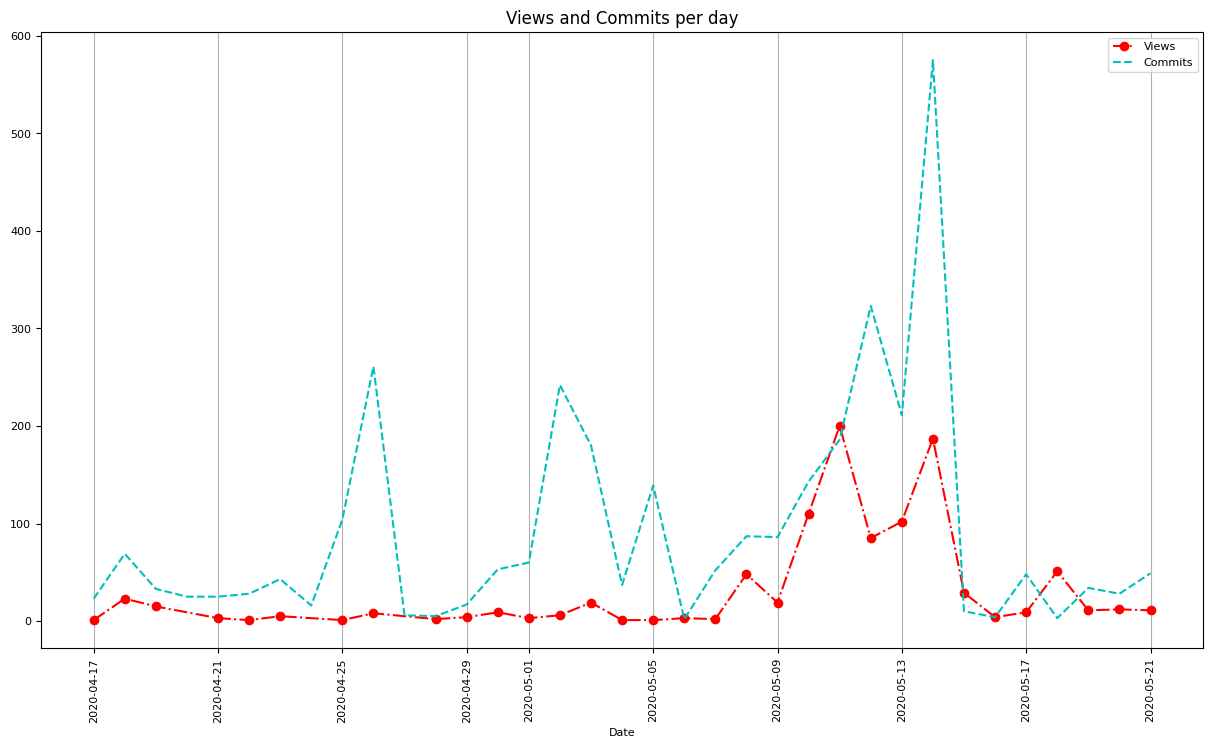

In [19]:
ax = views_per_day.plot(
    x='date',
    y='views',
    figsize=(15, 8),
    fontsize=8,
    linestyle='-.',
    label='Views',
    color='r',
    marker='o',
    title='Views and Commits per day',
)

commits_df.plot(
    x='date',
    y='commits',
    ax=ax,
    fontsize=8,
    color='c',
    linestyle='--',
    label='Commits',
)

ax.set_xlabel('Date', fontsize=8)
ax.tick_params(axis='x', rotation=90)
ax.legend(loc='upper right', fontsize=8)
ax.grid(axis='y', visible=False)
ax.grid(axis='x', visible=True)

## Закрываем соединение с БД

In [20]:
conn.close()

## “How many times was the number of views larger than 150?” Insert: “The answer is _`2`_”

In [21]:
(views_per_day['views'] > 150).sum()

np.int64(2)